# Setting Up

Please install the following packages if you don't have them yet, thank you!

In [ ]:
!pip install torch # Please install the CUDA version! 
!pip install pandas numpy
!pip install matplotlib
!pip install transformers

In [1]:
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import os
import time
import datetime

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup


Check that there is a GPU available so that PyTorch can leverage CUDA to speed up model training.

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))
print("CUDA version:", torch.version.cuda)

CUDA available: True
GPU name: NVIDIA GeForce GTX 1070
CUDA version: 11.8


In [3]:
print("Total GPU memory (GB):", torch.cuda.get_device_properties(0).total_memory / 1e9)
print("Allocated (GB):", torch.cuda.memory_allocated(0) / 1e9)
print("Reserved (GB):", torch.cuda.memory_reserved(0) / 1e9)


Total GPU memory (GB): 8.58980352
Allocated (GB): 0.0
Reserved (GB): 0.0


In [4]:
# Assign PyTorch to run off GPU
gpu = torch.device("cuda")
torch.cuda.empty_cache()

In [5]:
SEED = 127

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model Training and Validation

## Preparation

Loading in of the training dataset. From the [Dreddit paper](https://aclanthology.org/D19-6213.pdf), the dataset is nearly balanced, with 52.3% of the data (1,857 instances) labeled stressful. An initial inspection of the dataset indicates that it is clean, with no missing values or obvious outliers, so I will proceed on with tokenization. 

In [102]:
df_train = pd.read_csv("dreaddit-train.csv")
df_train.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [106]:
df_train.isnull().sum().sum()

0

In [107]:
df_train.describe()

,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
count,2838.000000,2838.000000,2838.000000,2.838000e+03,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,...,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,13751.999295,0.524313,0.808972,1.518107e+09,18.262156,4.684272,85.996124,35.240941,40.948231,67.044249,...,1.088001,1.120099,1.000211,1.722759,1.536400,1.879385,0.843517,9.948555,5.448836,0.040740
std,17340.161897,0.499497,0.177038,1.552209e+07,79.419166,3.316435,32.334887,26.486189,31.587117,32.880644,...,0.117159,0.085227,0.006500,0.047835,0.102971,0.058932,0.174794,21.798032,2.535829,0.195490
min,4.000000,0.000000,0.428571,1.483274e+09,0.000000,-6.620000,5.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.485400,1.200000,1.561150,0.140000,0.000000,-1.918000,-1.000000
25%,926.250000,0.000000,0.600000,1.509698e+09,2.000000,2.464243,65.000000,12.410000,12.135000,41.070000,...,1.000000,1.000000,1.000000,1.691430,1.469745,1.841782,0.750000,2.000000,3.729973,-0.072222
50%,1891.500000,1.000000,0.800000,1.517066e+09,5.000000,4.321886,81.000000,29.420000,33.520000,80.710000,...,1.000000,1.142900,1.000000,1.721430,1.530295,1.878250,0.890000,5.000000,5.210000,0.044821
75%,25473.750000,1.000000,1.000000,1.530898e+09,10.000000,6.505657,101.000000,55.057500,69.320000,96.180000,...,1.142900,1.142900,1.000000,1.751760,1.596030,1.916243,1.000000,10.000000,6.855217,0.166667
max,55757.000000,1.000000,1.000000,1.542592e+09,1435.000000,24.074231,310.000000,99.000000,99.000000,99.000000,...,1.900000,1.500000,1.200000,2.007400,2.066670,2.158490,1.000000,416.000000,21.198919,1.000000


In [ ]:
# Get the lists of post contents and their labels for training
text = df_train.text.values
labels = df_train.label.values

<class 'numpy.ndarray'>


## Tokenization

I'll be using BERT as my model. BERT is a transformers model pretrained on a large corpus of English data (like Wikipedia and BooksCorpus for ber-base-uncased) in a self-supervised fashion.  
Here, I convert raw text from the posts into token IDs that BERT can process, and used the bert-base-uncased model with pretrained weights from https://huggingface.co/google-bert/bert-base-uncased. Using a pretrained BERT model allows me to leverage knowledge learned from massive corpora without having to train a model from scratch, which is both computationally efficient and beneficial for performance. 

I specifically chose BERT for several reasons: 
- Contextual understanding: Unlike traditional models like Word2Vec which assign a single embedding per word regardless of context, BERT generates embeddings based on the surrounding context. This allows the model to distinguish nuanced meanings of words depending on the sentence.  

- Bidirectional encoding: BERT reads text in both directions (left-to-right and right-to-left), capturing richer context than than unidirectional models. This can be especially important in texts from social media, where phrasing can be informal, fragmented, or syntactically unconventional.  

- Strong performance: As demonstrated in the original Dreddit study, BERT demonstrated stronger performance compared to the other models.

Below is a sample of a tokenized post and how BERT converts texts from posts into token IDs for processing:

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print('  Original: ', text[0])
print('  Tokenized: ', tokenizer.tokenize(text[0]))
print('  Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[0])))

  Original:  He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.
  Tokenized:  ['he', 'said', 'he', 'had', 'not', 'felt', 'that', 'way', 'before', ',', 'su', '##gg', '##ete', '##d', 'i', 'go', 'rest', 'and', 'so', '.', '.', 'trigger', 'ahead', 'if', 'you', '##i', "'", 're', 'a', 'h', '##yp', '##oco', '##nd', '##ria', '##c', 'like', 'me', ':', 'i', 'decide', 'to', 'look', 'up', '"', 'feelings', 'of', 'doom', '"', 'in', 'hopes', 'of', 'maybe', 'getting', 'sucked', 'into', 'some

[CLS] stands for: "Classification token". BERT uses this token at the start of every input sequence for classification tasks. The output embedding corresponding to [CLS] contains the summary representation of the whole sentence.
[SEP] stands for: "Separator token". It marks the end of a sentence or separates two sentences.

Without adding these special tokens, BERT won't know the boundaries of the input. Thus, I will include in the special tokens here as well. 

In [ ]:
max_len = 0

for comment in text:
    # Tokenize post and add `[CLS]` and `[SEP]` tokens. 
    input_ids = tokenizer.encode(comment, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max post length in dataset: ', max_len)

Max post length in dataset:  378


BERT’s maximum token length is 512 tokens. I've confirmed that the max post length isn't longer than what BERT can handle. Now, I proceed with tokenizing the entire training dataset. 

In [ ]:
input_ids = []
attention_masks = []

for post in text:
    encoded_dict = tokenizer(
        post,                          # post to encode
        add_special_tokens=True,       # add [CLS] and [SEP]
        padding='max_length',          # pad sequences shorter than max_length
        return_attention_mask=True,    # create attention masks (to distinguish padding vs actual content tokens)
        return_tensors='pt'            # return PyTorch tensors
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

## Splitting of training data for validation

i randomly split 90% of the data for training and 10% for validation. Training set is used to train a few candidate models with different hyperparameter values (e.g. different learning rates), while validation set is used to evaluate the candidate model’s performance (on unseen data).

In [ ]:
# Combine token IDs, attention masks, and labels into a single PyTorch dataset
dataset = TensorDataset(input_ids, attention_masks, labels)

training_size = int(0.9 * len(dataset))
validation_size = len(dataset) - training_size

generator = torch.Generator().manual_seed(SEED)

training_set, validation_set = random_split(
    dataset,
    [training_size, validation_size],
    generator=generator
)

print('{:>8,} training samples'.format(training_size))
print('{:>8,} validation samples'.format(validation_size))

   2,554 training samples
     284 validation samples


## Determining best learning rate and epoch size

I now initialize a BERT model for binary sequence classification using the pretrained bert-base-uncased weights. 

In [ ]:
def init_model():
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) 
    return model.to(gpu)

I use F1 score as the evaluation metric. The model outputs logits, which are converted into binary predictions using a 0.5 threshold, and the F1 score is computed by comparing these predictions against the true labels.  

I use F1 score for evaluation because it balances precision and recall into a single metric, preventing the model from optimizing one at the expense of the other. Hopefully this can ensure that posts predicted as “Stress” are likely to genuinely reflect stress (precision), and posts where individuals expressing stress will likely not be overlooked (recall). 

In [16]:
from sklearn.metrics import f1_score
def flat_f1(logits, labels):
    preds = (logits > 0.5).astype(int)
    return f1_score(labels.flatten(), preds)

In [ ]:
# Helper function for checking elapsed time during train/val
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

I created a `train_and_eval` function to perform training and validation of my BERT model.  
After each epoch (i.e. a complete run through the entire training portion), the model is then evaluated on the validation set, computing predictions and the F1 score to measure performance. The training loss, validation loss and F1 for each epoch will also be reported.

In [ ]:
def train_and_eval(batch_size, learning_rate, num_epochs):

    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

    generator = torch.Generator().manual_seed(SEED)

    train_dataloader = DataLoader(
        training_set,
        sampler=RandomSampler(training_set, generator=generator),
        batch_size=batch_size,
        num_workers=0
    )

    validation_dataloader = DataLoader(
        validation_set,
        sampler=SequentialSampler(validation_set),
        batch_size=batch_size,
        num_workers=0
    )

    model = init_model()

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

    total_steps = len(train_dataloader) * num_epochs

    #learning rate scheduler that adjusts the optimizer’s learning rate over the course of training
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)  

    best_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        print('')
        print('----- Epoch {:} / {:} -----'.format(epoch+1, num_epochs))
        print('Training...')

        t0 = time.time()

        for batch in train_dataloader:
            batch_input_ids = batch[0].to(gpu)
            batch_attention_masks = batch[1].to(gpu)
            batch_labels = batch[2].to(gpu)

            output = model(
                batch_input_ids,
                attention_mask=batch_attention_masks,
                labels=batch_labels
            )

            loss = output.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            model.zero_grad()
        
        avg_train_loss = total_train_loss / len(train_dataloader)

        train_time = format_time(time.time()-t0)  
        
        print('')
        print('    Average training loss: {0:.2f}'.format(avg_train_loss))
        print('    Training epoch took: {:}'.format(train_time))


        # -------- Validation --------
        print('')
        print('Running Validation...')
        t0 = time.time()

        model.eval()
    
        total_val_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in validation_dataloader:
                batch_input_ids = batch[0].to(gpu)
                batch_attention_masks = batch[1].to(gpu)
                batch_labels = batch[2].to(gpu)

                output = model(
                    batch_input_ids,
                    attention_mask=batch_attention_masks,
                    labels=batch_labels
                )

                loss = output.loss
                total_val_loss += loss.item()

                logits = output.logits.detach().cpu().numpy()
                labels = batch_labels.detach().cpu().numpy()
                preds = np.argmax(logits, axis=1)
                all_preds.extend(preds)
                all_labels.extend(labels)

        avg_val_loss = total_val_loss / len(validation_dataloader)
        epoch_f1 = f1_score(all_labels, all_preds)
        best_f1 = max(best_f1, epoch_f1)

        eval_time = format_time(time.time()-t0)

        
        print(f'    Validation Loss: {avg_val_loss:.4f}')
        print('    Validation Time: {:}'.format(eval_time))
        print(f'    F1 Score: {epoch_f1:.4f}')

    return best_f1

According to this [Deep Learning Tuning Playbook](https://github.com/google-research/tuning_playbook?tab=readme-ov-file#choosing-the-batch-size) by reserachers from Google and Harvard, batch size mostly governs the training speed and shouldn't be used to directly tune the validation set performance. i.e. batch size is a key factor in determining the training time and computing resource consumption, but shouldn't be treated as a tunable hyperparameter for validation set performance. Hence, I fix a batch size of 32 for testing all my different combinations of hyperparameters as recommended in the [BERT paper](https://aclanthology.org/N19-1423.pdf). 

I perform a grid search over learning rates of 2e-5, 3e-5, and 5e-5 as recommended by the BERT paper. For each learning rate, the model is trained for up to 5 epochs. At every epoch, I compute the training loss, validation loss, and validation F1 score. The optimal configuration of hyperparameters (learning rate + epoch size) is selected based on the highest validation F1 score observed during training, with early stopping applied implicitly by selecting the epoch corresponding to peak validation performance.

In [19]:
learning_rates = [2e-5, 3e-5, 5e-5]
epochs = 5
batch_size = 32

In [ ]:
results = []

best_overall_f1 = 0
best_config = None

for lr in learning_rates:
    
    f1 = train_and_eval(batch_size, lr, epochs)
    
    if f1 > best_overall_f1:
        best_overall_f1 = f1

print("\n==============================")
print(f"Best F1: {best_overall_f1:.4f}")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



----- Epoch 1 / 5 -----
Training...

    Average training loss: 0.50
    Training epoch took: 0:23:42

Running Validation...
    Validation Loss: 0.3970
    Validation Time: 0:00:15
    F1 Score: 0.8402

----- Epoch 2 / 5 -----
Training...

    Average training loss: 0.32
    Training epoch took: 0:23:36

Running Validation...
    Validation Loss: 0.3572
    Validation Time: 0:00:15
    F1 Score: 0.8571

----- Epoch 3 / 5 -----
Training...

    Average training loss: 0.21
    Training epoch took: 0:25:25

Running Validation...
    Validation Loss: 0.4027
    Validation Time: 0:00:13
    F1 Score: 0.8481

----- Epoch 4 / 5 -----
Training...

    Average training loss: 0.13
    Training epoch took: 0:27:02

Running Validation...
    Validation Loss: 0.5088
    Validation Time: 0:00:17
    F1 Score: 0.8462

----- Epoch 5 / 5 -----
Training...

    Average training loss: 0.09
    Training epoch took: 0:26:35

Running Validation...
    Validation Loss: 0.5470
    Validation Time: 0:00:16
 

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



----- Epoch 1 / 5 -----
Training...

    Average training loss: 0.49
    Training epoch took: 0:27:49

Running Validation...
    Validation Loss: 0.4085
    Validation Time: 0:00:33
    F1 Score: 0.8434

----- Epoch 2 / 5 -----
Training...

    Average training loss: 0.28
    Training epoch took: 0:27:18

Running Validation...
    Validation Loss: 0.3686
    Validation Time: 0:00:31
    F1 Score: 0.8519

----- Epoch 3 / 5 -----
Training...

    Average training loss: 0.16
    Training epoch took: 0:25:13

Running Validation...
    Validation Loss: 0.4772
    Validation Time: 0:00:28
    F1 Score: 0.8517

----- Epoch 4 / 5 -----
Training...

    Average training loss: 0.07
    Training epoch took: 0:24:03

Running Validation...
    Validation Loss: 0.6529
    Validation Time: 0:00:28
    F1 Score: 0.8395

----- Epoch 5 / 5 -----
Training...

    Average training loss: 0.04
    Training epoch took: 0:27:03

Running Validation...
    Validation Loss: 0.6672
    Validation Time: 0:00:41
 

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



----- Epoch 1 / 5 -----
Training...

    Average training loss: 0.49
    Training epoch took: 0:29:18

Running Validation...
    Validation Loss: 0.4191
    Validation Time: 0:00:39
    F1 Score: 0.8218

----- Epoch 2 / 5 -----
Training...

    Average training loss: 0.25
    Training epoch took: 0:29:28

Running Validation...
    Validation Loss: 0.4055
    Validation Time: 0:00:40
    F1 Score: 0.8348

----- Epoch 3 / 5 -----
Training...

    Average training loss: 0.11
    Training epoch took: 0:31:14

Running Validation...
    Validation Loss: 0.5727
    Validation Time: 0:00:28
    F1 Score: 0.8411

----- Epoch 4 / 5 -----
Training...

    Average training loss: 0.04
    Training epoch took: 0:25:27

Running Validation...
    Validation Loss: 0.7756
    Validation Time: 0:00:28
    F1 Score: 0.8395

----- Epoch 5 / 5 -----
Training...

    Average training loss: 0.02
    Training epoch took: 0:25:18

Running Validation...
    Validation Loss: 0.8241
    Validation Time: 0:00:28
 


I printed the outputs from each candidate model across all five epochs above. However, I forgot to store my results in a dataframe at the time. To avoid unnecessary recomputation, I manually compiled the recorded values into the summary table presented below.

In [20]:
learning_rates = [2e-5, 2e-5, 2e-5, 2e-5, 2e-5, 3e-5, 3e-5, 3e-5, 3e-5, 3e-5, 5e-5, 5e-5, 5e-5, 5e-5, 5e-5]
epoch_size = [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5]  
train_loss = [0.50, 0.32, 0.21, 0.13, 0.09, 
              0.49, 0.28, 0.16, 0.07, 0.04,
              0.49, 0.25, 0.11, 0.04, 0.02]
val_loss = [0.3970, 0.3572, 0.4027, 0.5088, 0.5470, 
            0.4085, 0.3686, 0.4772, 0.6529, 0.6672,
            0.4191, 0.4055, 0.5727, 0.7756, 0.8241]
f1_scores = [0.8402, 0.8571, 0.8481, 0.8462, 0.8471, 
             0.8434, 0.8519, 0.8517, 0.8395, 0.8517,
             0.8218, 0.8348, 0.8411, 0.8395, 0.8375]

df_results = pd.DataFrame({
    'learning_rate': learning_rates,
    'epoch_size': epoch_size,
    'train_loss': train_loss,
    'val_loss': val_loss,
    'f1_scores': f1_scores
})

print(df_results)

    learning_rate  epoch_size  train_loss  val_loss  f1_scores
0         0.00002           1        0.50    0.3970     0.8402
1         0.00002           2        0.32    0.3572     0.8571
2         0.00002           3        0.21    0.4027     0.8481
3         0.00002           4        0.13    0.5088     0.8462
4         0.00002           5        0.09    0.5470     0.8471
5         0.00003           1        0.49    0.4085     0.8434
6         0.00003           2        0.28    0.3686     0.8519
7         0.00003           3        0.16    0.4772     0.8517
8         0.00003           4        0.07    0.6529     0.8395
9         0.00003           5        0.04    0.6672     0.8517
10        0.00005           1        0.49    0.4191     0.8218
11        0.00005           2        0.25    0.4055     0.8348
12        0.00005           3        0.11    0.5727     0.8411
13        0.00005           4        0.04    0.7756     0.8395
14        0.00005           5        0.02    0.8241    

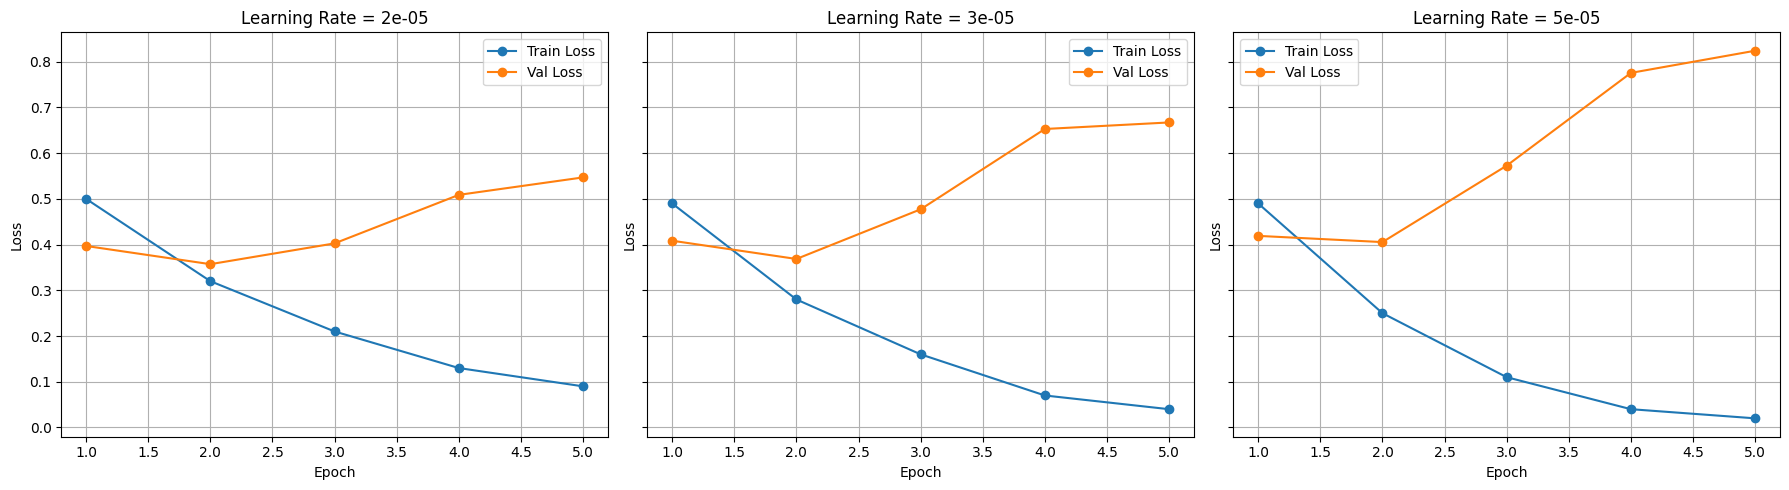

In [ ]:
learning_rates = df_results["learning_rate"].unique()

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

for ax, lr in zip(axes, learning_rates):
    subset = df_results[df_results["learning_rate"] == lr]
    
    ax.plot(subset["epoch_size"], subset["train_loss"], 
            marker='o', label="Train Loss")
    ax.plot(subset["epoch_size"], subset["val_loss"], 
            marker='o', label="Validation Loss")
    
    ax.set_title(f"Learning Rate = {lr}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


The plots for train vs validation loss across different epochs for the 3 learning rates show: 
- Best validation performance at around epoch 2, and clear overfitting from epoch 3 onward
- Higher learning rate results in faster and worse overfitting  

I'll select the hyperparameter combination that achieved the highest validation F1 score of 0.8571 without showing signs of overfitting (`Batch size = 32`, `Learning rate: 2e-05` and `epoch = 2`) to train the final model. 

## Final Training

My trained final model has been saved as a `.pkl` file, and I've included the file along with the notebook contents on my DSA4262 GitHub repository as well. Please use that .pkl file to run the analysis sections, thank you!

In [ ]:
epochs = 2

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

generator = torch.Generator().manual_seed(SEED)

train_dataloader = DataLoader(
    dataset,
    sampler=RandomSampler(dataset, generator=generator),
    batch_size=32,
    num_workers=0
)

model = init_model()

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-05, eps=1e-8)

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)  

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    print('')
    print('----- Epoch {:} / {:} -----'.format(epoch+1, epochs))
    print('Training...')

    t0 = time.time()

    for batch in train_dataloader:
        batch_input_ids = batch[0].to(gpu)
        batch_attention_masks = batch[1].to(gpu)
        batch_labels = batch[2].to(gpu)

        output = model(
            batch_input_ids,
            attention_mask=batch_attention_masks,
            labels=batch_labels
        )

        loss = output.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        model.zero_grad()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    train_time = format_time(time.time()-t0)  
    
    print('')
    print('    Average training loss: {0:.2f}'.format(avg_train_loss))
    print('    Training epoch took: {:}'.format(train_time))

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



----- Epoch 1 / 2 -----
Training...

    Average training loss: 0.49
    Training epoch took: 0:29:42

----- Epoch 2 / 2 -----
Training...

    Average training loss: 0.32
    Training epoch took: 0:29:48


In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
print('Model saved: ' + os.getcwd() + '\\model.pkl')

Model saved: c:\Users\yuant\OneDrive\Documents\DSA4262\Assignment 2\model.pkl
